# Fitting a normal distribution with tensorflow probability

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

Generate some data from a normal distribution:

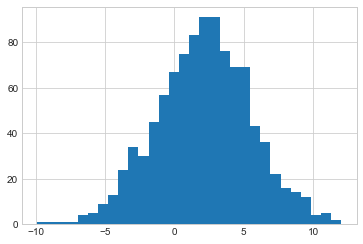

In [2]:
n = 1000
true_mu = 2.0
true_std = 3.4
x = np.random.normal(loc=true_mu, scale=true_std, size=n)
plt.hist(x, 30)
plt.show()

# Model setup
Tensorflow probability allows us to fit a network where the final layer output is not a scalar value,
but a probability distribution.
The normal distribution is parameterised by the mean and standard deviation.
As such the model needs to output two values.

We are fitting just a static distribution to the data.
This is equivalent to fitting a network where the inputs are all 0.
In this situation we only use the network biases as the weights become irrelevant with inputs of 0.

To build the above - the model has a dense layer with 2 output nodes.
For the final output layer we utilise the normal distribution object from tensorflow probability.
The `DistributionLambda` layer allows us to use a lambda function to split the dense layer outputs
and connect them to the `loc` and `scale` (mean and standard deviation) inputs of the normal distribution.
The scale uses a `softplus` function to ensure the standard deviation is always positive.

In [3]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(1 + 1),
        tfp.layers.DistributionLambda(
            lambda t: tfp.distributions.Normal(
                loc=t[..., :1],
                scale=1e-3 + tf.math.softplus(0.05 * t[..., 1:]),
            )
        ),
    ]
)

The cost function is setup as the negative loglikelihood:
Tensorflow probably objects have a `log_prob(y)` method which returns the log probablility of the sample `y`.

In [4]:
def negloglik(y, distr):
    return -distr.log_prob(y)

We fit the model as normal using gradient descent and the `Adam` optimiser.
As mentioned before, the input to the network is a vector of zeros.
The target variable is our random data we want to fit the normal distribution to.

In [5]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.2), loss=negloglik)

dummy_input = np.zeros(x.shape)[:, np.newaxis]
history = model.fit(dummy_input, x, epochs=100, verbose=0)

The loglikelihood has converged over the training:

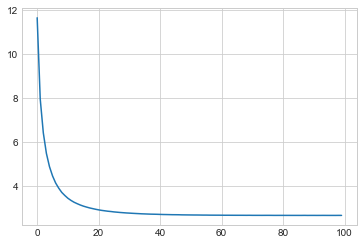

In [6]:
plt.plot(history.history['loss'])
plt.show()

# Results
We can obtain the fitted parameters from the `model.weights` biases.
They do not match the exact parameters of the true distribution.
They converge to the maximum likelihood estimator for a normal distribution.
In this case it corresponds to the sample mean and standard deviation.

We can compare these different estimates by creating probability distribution objects
and then plotting the probability distribution function.
As we can see the estimates are reasonable approximations of the true distribution.

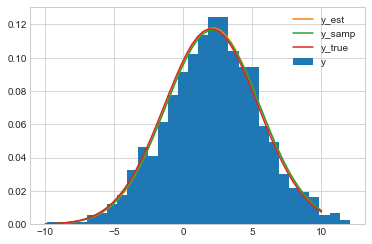

In [7]:
p_y1 = tfp.distributions.Normal(
    loc=model.weights[1][0], scale=tf.math.softplus(0.05 * model.weights[1][1])
)
p_y2 = tfp.distributions.Normal(loc=np.mean(x), scale=np.std(x))
p_y3 = tfp.distributions.Normal(loc=true_mu, scale=true_std)

x_t = np.linspace(-10, 10, 50)
y_t1 = p_y1.prob(x_t)
y_t2 = p_y2.prob(x_t)
y_t3 = p_y3.prob(x_t)

plt.hist(x, bins=30, density=True, label="y")
plt.plot(x_t, y_t1, label="y_est")
plt.plot(x_t, y_t2, label="y_samp")
plt.plot(x_t, y_t3, label="y_true")
plt.legend()
plt.show()